# T5

In [168]:
import pandas as pd
import numpy as np
import torch
import json
import wandb
from transformers import AutoModelForSequenceClassification, T5Tokenizer, TrainingArguments, DataCollatorWithPadding, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix,classification_report
from datasets import Dataset, DatasetDict
import datetime

In [169]:
config_data = json.load(open('../config.json'))
HF_TOKEN = config_data['HF_TOKEN']
WANDB_TOKEN = config_data['WANDB_TOKEN']

wandb.login(key=WANDB_TOKEN)

model_name = "google-t5/t5-base"

config = {
    "per_device_train_batch_size":8,
    "per_device_eval_batch_size":8,
    "num_train_epochs":2,
    "learning_rate":5e-5,
    "maxlen": 1000,
    "logging_steps": 10,
    "num_classes": 6,
    "num_labels":6,
    "use_cache":False,
    "pretraining_tp":1,
    "model_name": model_name
}

run = wandb.init(
    project='wz_experimental',
    config=config
)


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\kawis\_netrc


In [170]:
id_to_label_mapping = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}
label_to_id_mapping = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
cefr_levels = ["A1", "A2", "B1", "B2", "C1", "C2"]

In [171]:
train = pd.read_csv('../datasets/quotes/quotes_train.csv')
test = pd.read_csv('../datasets/quotes/quotes_test.csv')
validation = train.sample(2091, random_state=42)
train = train.drop(validation.index)

train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)
validation = validation.sample(frac=1).reset_index(drop=True)

In [172]:
dataset = DatasetDict({
    'train': Dataset.from_pandas(train),
    'val': Dataset.from_pandas(validation),
    'test': Dataset.from_pandas(test)
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'level'],
        num_rows: 16130
    })
    val: Dataset({
        features: ['text', 'label', 'level'],
        num_rows: 2091
    })
    test: Dataset({
        features: ['text', 'label', 'level'],
        num_rows: 2692
    })
})

In [173]:
def check_labels_range(dataset):
    unique_labels = set(dataset['train']['label'])
    print(f"Unique labels in the training dataset: {unique_labels}")
    assert all(label in range(6) for label in unique_labels), "Labels must be in the range 0 to 5"

check_labels_range(dataset)

Unique labels in the training dataset: {0, 1, 2, 3, 4, 5}


In [174]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6, config=config)
model.to(device)
print("Added to device")

Using device: cuda


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google-t5/t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Added to device


In [175]:
tokenizer = T5Tokenizer.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [176]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [177]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=config['maxlen'])

tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=['text'])
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/16130 [00:00<?, ? examples/s]

Map:   0%|          | 0/2091 [00:00<?, ? examples/s]

Map:   0%|          | 0/2692 [00:00<?, ? examples/s]

In [178]:
def compute_metrics(pred):
    print(pred)
    print(f'Label: {str(pred.label_ids)[:60]}')
    print(f'Pred: {str(pred.predictions)[:60]}')
    print(f'Input: {str(pred.inputs)[:60]}')
    labels = pred.label_ids
    predictions = pred.predictions[0].argmax(-1)

    m_accuracy = accuracy_score(labels, predictions)

    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')

    return {
        'accuracy': m_accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [179]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    logging_steps=config['logging_steps'],
    per_device_train_batch_size=config['per_device_train_batch_size'],
    per_device_eval_batch_size=config['per_device_eval_batch_size'],
    num_train_epochs=config['num_train_epochs'],
    fp16=True,
    report_to="wandb",
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    learning_rate=config['learning_rate'],
)

In [180]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'].shuffle(seed=42),
    eval_dataset = tokenized_datasets['val'].shuffle(seed=42),
    tokenizer = tokenizer,
    data_collator = collate_fn,
    compute_metrics = compute_metrics
)

In [181]:
train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.828100,0.709904,0.694883,0.692001,0.694883,0.690726
2,0.562100,0.669504,0.723099,0.719337,0.723099,0.720810


Label: [1 0 1 ... 0 0 4]
Pred: (array([[ 4.4921875 ,  4.3867188 ,  0.12683105, -3.1542969 ,
Input: None


C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Label: [1 0 1 ... 0 0 4]
Pred: (array([[ 4.2617188 ,  5.0625    ,  0.58251953, -3.5234375 ,
Input: None


C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
There were missing keys in the checkpoint model loaded: ['transformer.encoder.embed_tokens.weight', 'transformer.decoder.embed_tokens.weight'].


In [182]:
trainer.evaluate()

Label: [1 0 1 ... 0 0 4]
Pred: (array([[ 4.2617188 ,  5.0625    ,  0.58251953, -3.5234375 ,
Input: None


C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.6695042252540588,
 'eval_accuracy': 0.7230989956958394,
 'eval_precision': 0.71933745940503,
 'eval_recall': 0.7230989956958394,
 'eval_f1': 0.7208096339142355,
 'eval_runtime': 114.7007,
 'eval_samples_per_second': 18.23,
 'eval_steps_per_second': 2.284,
 'epoch': 2.0}

In [183]:
model.config.use_cache = True

In [184]:
trainer.save_model('model')
tokenizer.save_pretrained('model')

('model\\tokenizer_config.json',
 'model\\special_tokens_map.json',
 'model\\spiece.model',
 'model\\added_tokens.json')

In [185]:
def make_predictions(p_model, p_test):
    print(f'Started prediction at {datetime.datetime.now()}')
    sentences = p_test.text.tolist()

    batch_size = 32

    all_outputs = []

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i + batch_size]

        inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=1000)

        inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

        with torch.no_grad():
            outputs = p_model(**inputs)
            all_outputs.append(outputs['logits'])

    final_outputs = torch.cat(all_outputs, dim=0)
    p_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
    p_test['predictions']=p_test['predictions'].apply(lambda l:id_to_label_mapping[l])


make_predictions(model,test)

Started prediction at 2024-08-29 17:06:39.692932


Accuracy: 0.722
Accuracy for label A1: 0.887
Accuracy for label A2: 0.689
Accuracy for label B1: 0.557
Accuracy for label B2: 0.703
Accuracy for label C1: 0.535
Accuracy for label C2: 0.000

Classification Report:
              precision    recall  f1-score   support

          A1       0.85      0.89      0.87       853
          A2       0.72      0.69      0.70       753
          B1       0.55      0.56      0.55       442
          B2       0.67      0.70      0.69       492
          C1       0.66      0.54      0.59       142
          C2       0.00      0.00      0.00        10

    accuracy                           0.72      2692
   macro avg       0.57      0.56      0.57      2692
weighted avg       0.72      0.72      0.72      2692


Confusion Matrix:
[[757  92   3   1   0   0]
 [132 519  90  12   0   0]
 [  2 106 246  86   2   0]
 [  0   7 107 346  32   0]
 [  0   1   1  64  76   0]
 [  0   0   0   4   6   0]]


C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kawis\anaconda3\Lib\site-packag

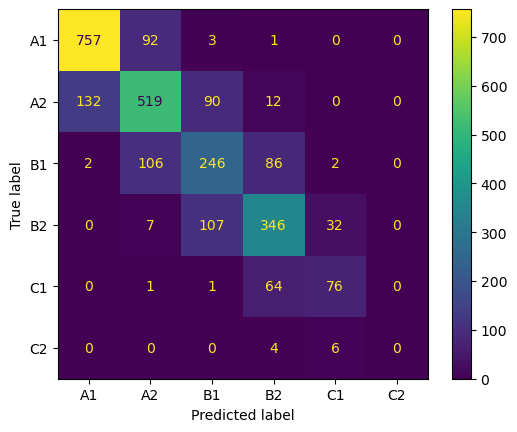

In [186]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import wandb

train['level'] = train['label'].apply(lambda x: id_to_label_mapping[x])
test['level'] = test['label'].apply(lambda x: id_to_label_mapping[x])

y_pred = test['predictions']

y_true = test['level']

def map_func(x):
    return label_to_id_mapping.get(x, -1)

y_true_mapped = np.vectorize(map_func)(y_true)
y_pred_mapped = np.vectorize(map_func)(y_pred)

accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
print(f'Accuracy: {accuracy:.3f}')

unique_labels = set(y_true_mapped)

for label in unique_labels:
    label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
    label_y_true = [y_true_mapped[i] for i in label_indices]
    label_y_pred = [y_pred_mapped[i] for i in label_indices]
    label_accuracy = accuracy_score(label_y_true, label_y_pred)
    print(f'Accuracy for label {cefr_levels[label]}: {label_accuracy:.3f}')

class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))))
class_report_dict = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))), output_dict=True)


print('\nClassification Report:')
print(class_report)


table_data = []

for key, value in class_report_dict.items():
    if isinstance(value, dict):
        table_data.append([
            key,
            value.get("precision", 0),
            value.get("recall", 0),
            value.get("f1-score", 0),
            value.get("support", 0)
        ])
    else:
        table_data.append([
            key,
            0,
            0,
            value,
            class_report_dict["weighted avg"]["support"]
        ])

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(cefr_levels))))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=cefr_levels)
disp.plot()


print('\nConfusion Matrix:')
print(conf_matrix)

wandb.log({
    "Class Proportions": wandb.sklearn.plot_class_proportions(train['level'], test['level'], cefr_levels),
    "Confusion Matrix": plt,
    "Classification Report": wandb.Table(data=table_data, columns=['Class/Metric', 'Precision', 'Recall', 'F1-score', 'Support'])
})

In [187]:
print(f'Ended prediction at {datetime.datetime.now()}')
wandb.finish()

Ended prediction at 2024-08-29 17:11:31.354179


eval/accuracy,▁██
eval/f1,▁██
eval/loss,█▁▁
eval/precision,▁██
eval/recall,▁██
eval/runtime,█▁▁
eval/samples_per_second,▁██
eval/steps_per_second,▁██
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,▁▂▄▄▅▆▆▇▂▄▄▂▃▄▃▄▅▃▃▅▂▄▅▅█▅▆▆▃▇▄▄▄▆█▄▄▄▃▁
